In [1]:
import datetime
import os
import pickle
import itertools
import requests
import time
from math import radians, cos, sin, asin, sqrt

# Api-Schlüssel
Der API-Schlüssel wird benötigt, um Anfragen an openrouteservice.org zu senden. Damit sind wir berechtigt, Anfragen abzuschicken.

In [2]:
api_key = '5b3ce3597851110001cf624883da24157f5c4b7bb731cb0ff99243cd'

# Allgemeiner Hintergrund
In Ostbayern soll eine neues Glasfaser-Netz verlegt werden. Eine Anbindung (aus südlicher
Richtung) hat aktuell nur München. Von dort aus sollen folgende Städte angeschlossen werden (Die Pythonliste dieser Städte (+ München) bezeichnen wir mit R)

In [3]:
R = ["München", "Augsburg", "Ingolstadt", "Regensburg", "Landshut", "Straubing", "Passau", "Deggendorf", "Burghausen", "Weißenburg-Gunzenhausen"]

Aufgrund rechtlicher Einschränkungen können zusätzliche Verzweigungsstellen nur an folgenden Orten realisiert werden (Die Pythonliste dieser Städte wird im folgenden mit S bezeichnet)

In [4]:
S = ["Freising", "Moosburg", "Vilsbiburg", "Landau", "Mainburg", "Abensberg", "Schierling", "Schrobenhausen", "Erding", "Pfarrkirchen", "Osterhofen", "Eichstätt", "Neuburg", "Kösching", "Pfaffenhofen"]

V ist die Vereinigung von R und S

In [5]:
V = R + S

# Api vorbereiten
Im nächsten Schritt möchten wir die API-Technologien von openrouteservice.org vorbereiten, z.B. um eine Koordinate einer Stadt abzurufen. Es ist sehr wichtig, so wenig API-Anfragen wie möglich zu senden, da die Nutzung für kostenlose Accounts begrenzt ist. Hier ist eine Übersicht, was wir dürfen.

Quelle: https://openrouteservice.org/dev/#/home
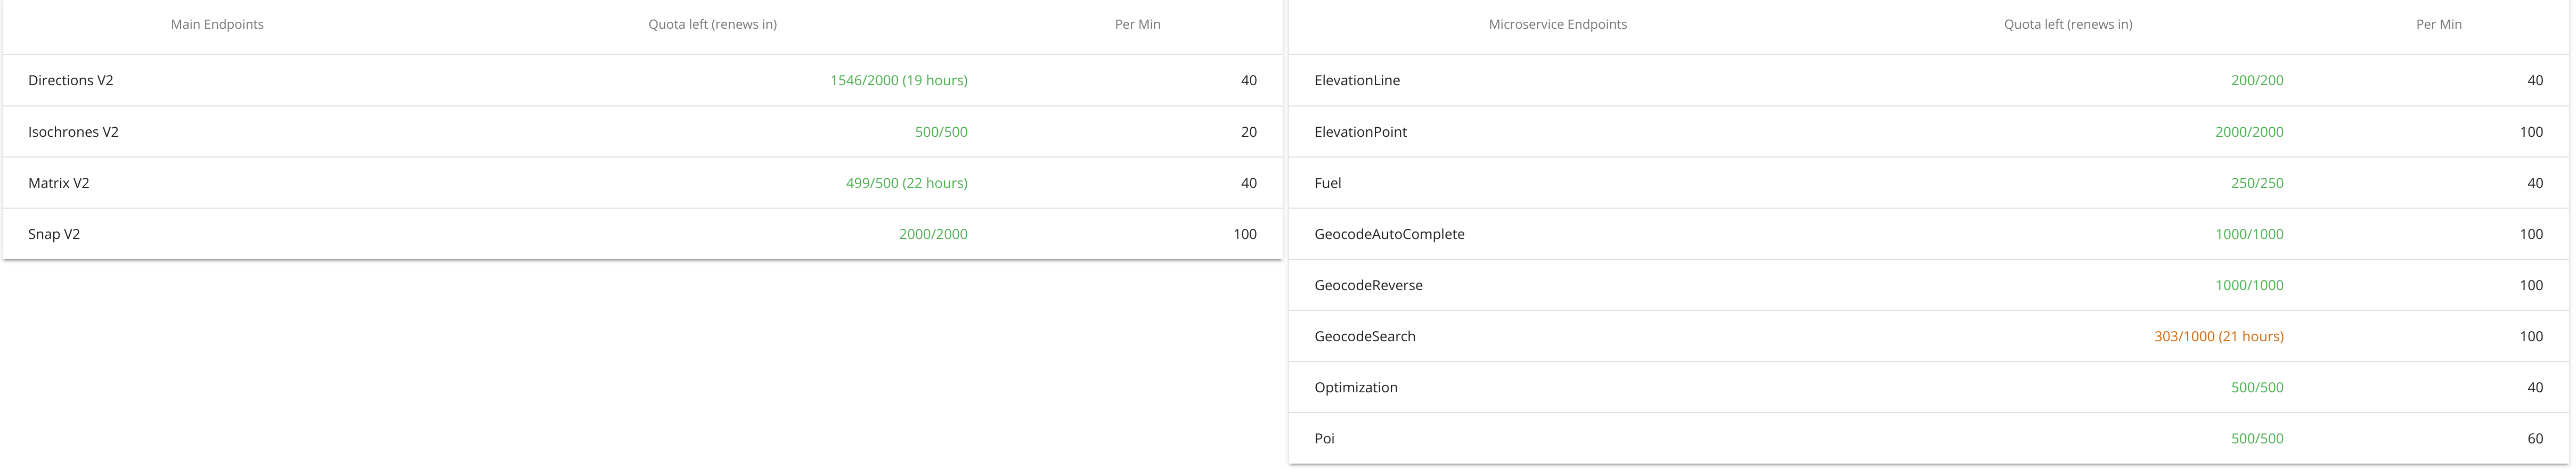

### Vereinfachte Darstellung einer API-Anfrage
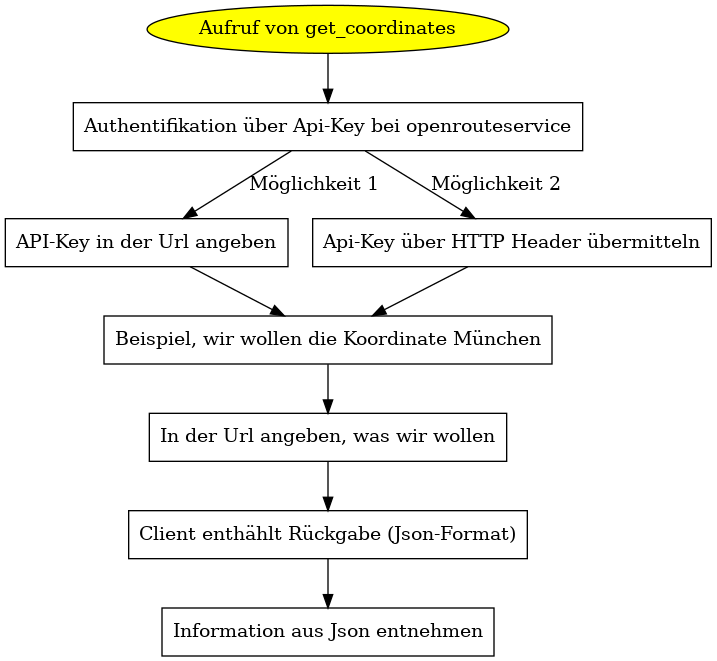

### Koordinate einer spezifischen Stadt
Zuerst definieren wir die Methode `get_coordinates(staedte)`. Wenn wir dieser Methode eine Liste mit Städten als Strings übergeben, erhalten wir als Rückgabewert ein Dictionary. Jedes Element des Dictionaries hat den Stadtname als Schlüssel und die Koordinaten als Wert, zum Beispiel 'München': (11.544467, 48.152126). Die benötigte API-Anfrage lautet `https://api.openrouteservice.org/geocode/search`. Mit der `requests` Bibliothek können wir einstellen, dass wir die Antwort im Json-Format erhalten möchten.

In [6]:
def get_coordinates(staedte): 
    url = f'https://api.openrouteservice.org/geocode/search?api_key={api_key}&text='

    koordinaten_dict = {}
    for stadt in staedte:
        # HTTP-Anfrage senden
        response = requests.get(url + str(stadt))
        
        # Antwort im JSON-Format
        data = response.json()
        
        # Koordinaten extrahieren
        if 'features' in data and data['features']:
            koordinaten = data['features'][0]['geometry']['coordinates']
            longitude = koordinaten[0]
            latitude = koordinaten[1]
            koordinaten_dict[stadt] = (longitude,latitude) #f"{longitude},{latitude}"
        else:
            koordinaten_dict[stadt] = 'Nicht gefunden'

    return koordinaten_dict

### Abstandt zwischen zwei Städte
Wir können den Abstand zwischen zwei Städten mit der API-Anfrage: `https://api.openrouteservice.org/v2/directions/driving-car` ermitteln. Dabei steht `driving-car` in der URL für die Route, die für ein Auto befahrbar wäre.

In [7]:
cooldown = 0  # In der kostenlosen Version dürfen wir leider nur 40 Berechnungen pro Minute durchführen, daher der Cooldown. Wenn die Funktion aufgerufen wird, müssen wir ca. 60 (+5 Tolleranz) Sekunden warten.

def get_distance_between_locations(loc1, loc2):
    global cooldown
    cooldown += 1
    
    if cooldown == 40:
        print("Cooldown von 65 Sekunden wurde gestartet, um weitere Anfragen zu gewährleisten.")
        time.sleep(65)  # Etwas Toleranz, falls die API nicht ordentlich reagiert.
        cooldown = 0  # API-Anfragen wieder erlaubt
    
    start_coords = str(koordinaten_dict[loc1][0]) + ',' + str(koordinaten_dict[loc1][1])
    end_coords = str(koordinaten_dict[loc2][0]) + ',' + str(koordinaten_dict[loc2][1])

    # Konstruiere die Request-URL
    url = f'https://api.openrouteservice.org/v2/directions/driving-car?api_key={api_key}&start={start_coords}&end={end_coords}'
    try:
        # Sende die Anfrage an die OpenRouteService API
        response = requests.get(url)
        response.raise_for_status()  # Werfe eine Ausnahme bei HTTP-Fehlern
    
        # Parsen der JSON-Antwort
        data = response.json()
    
        # Überprüfen, ob der Schlüssel 'features' in der Antwort ist
        if 'features' in data and len(data['features']) > 0:
            # Zugriff auf die Eigenschaften des ersten Features
            properties = data['features'][0]['properties']
    
            # Überprüfen, ob der Schlüssel 'summary' in den Eigenschaften ist
            if 'summary' in properties:
                summary = properties['summary']
    
                # Überprüfen, ob der Schlüssel 'distance' in 'summary' ist
                if 'distance' in summary:
                    distance = summary['distance']
                    return distance / 1000
                else:
                    print("Fehler: 'distance' Schlüssel nicht in 'summary' gefunden")
            else:
                print("Fehler: 'summary' Schlüssel nicht in Eigenschaften gefunden")
        else:
            print("Fehler: 'features' Schlüssel nicht in der Antwort gefunden oder keine Features vorhanden")
    
    except requests.exceptions.RequestException as e:
        print(f"Fehler: {e}")


### Optimierung der API-Anfragen
Im gesamten Projekt wollen wir die Anzahl der API-Anfragen minimieren, da diese nicht nur limitiert sind, sondern diese auch viel Zeit in Anspruch nehmen. Hierzu haben wir uns folgendes überlegt (Wir wollen immer den „Ja-Fall“ im Flowchart). 

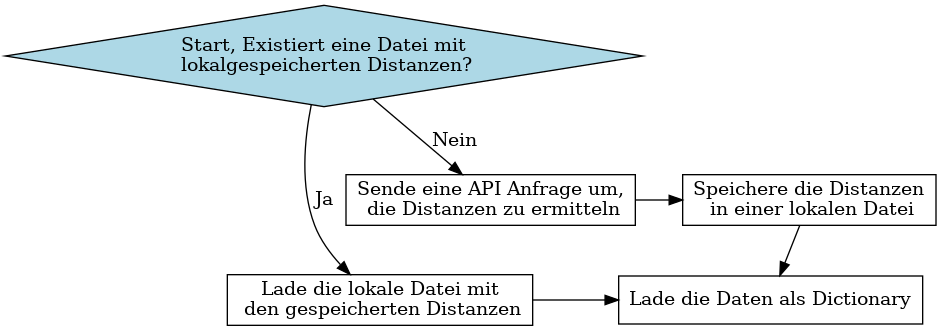

Diese Überlegung benutzen wir für
- Koordinaten aller Städte, die in R + S sind
- Alle möglichen Distanzen für die Liste R
- Alle möglichen Distanzen für die Liste S + R

Diese werden im Folgenden erklärt

#### Koordinaten aller Städte die in R + S sind

Zuerst wollen wir die Koordinaten ermitteln, diese brauchen wir gleich. um den Abstand zwischen zwei Orten auszurechnen. Außerdem brauchen wir die Koordinaten, um die Knoten auf dem Graphen etwas realistischer zu positionieren, dies werden wir jedoch erst am Schluss als Erweiterung tun. 

In [8]:
koordinaten_dict = {}
coordinatesDaten = 'coordinates.pkl'

if os.path.exists(coordinatesDaten): # Existiert die Datei?
    with open('coordinates.pkl', 'rb') as f:
        koordinaten_dict = pickle.load(f) # Lade die lokale Datei mit den gespeicherten Distanzen
    print("Hinweis: HTTPS Abfrage übersprungen") # D.h. eine Datei mit den Daten existiert.
else:
    koordinaten_dict = get_coordinates(V) # Sende eine Api Anfrage...
    with open('coordinates.pkl', 'wb') as f:
        pickle.dump(koordinaten_dict, f) # Speichere die die Daten in eine Datei

Hinweis: HTTPS Abfrage übersprungen


#### Alle möglichen Distanzen für die Liste R
Wir wollen einen Spannbaum für R ermitteln, hierzu benötigen wir die Distanzen zwischen den Großestädten. Die Anzahl der Distanzen ergibt sich durch den Binomialkoeffizienten, d.h. $10 \choose 2$ = $|R| \choose 2$ = 45. Die zwei For-Schleifen dienen als Kombinationsalgorithmus. Da wir außerdem ohne Zurücklegen ziehen, müssen Distanzen wie "München nach München" ausgeschlossen werden. Dies können wir mit einer einfachen if-Abfrage innerhalb der letzten For-Schleife tun.

In [9]:
# Das Schema wiederholt sich vgl. vorherigen Code
distances = {}
distancesDaten = 'distances.pkl'
if os.path.exists(distancesDaten):
    with open('distances.pkl', 'rb') as f:
        distances = pickle.load(f)
    print("Hinweis: HTTPS Abfrage übersprungen") 
else:
    for x in R:
        for y in R:
            if x != y:
                if (x, y) not in distances and (y, x) not in distances:
                    distance = get_distance_between_locations(x, y)
                    distances[(x, y)] = distance                    
    with open('distances.pkl', 'wb') as f:
        pickle.dump(distances, f)

Hinweis: HTTPS Abfrage übersprungen


#### Alle möglichen Distanzen für die Liste S + R
Wir ermitteln alle Abstände (d.h. den kürzesten Weg entlang der Straßen) zwischen je zwei Punkten. Insgesamt müssen jetzt (und später) 300 Distanzen bestimmt werden. Die Anzahl der Distanzen ergibt sich durch den Binomialkoeffizienten, d.h. $25 \choose 2$ = $|R|+|S| \choose 2$ = 300. Um durch die Kombinationen zu iterieren, können wir auch hier zwei For-Schleifen benutzen.

In [10]:
# Das Schema wiederholt sich vgl. vorherigen Code
distancesAll = {}
distancesAllDaten = 'distancesAll.pkl'

if os.path.exists(distancesAllDaten): 
    with open('distancesAll.pkl', 'rb') as f:
        distancesAll = pickle.load(f)
    print("Hinweis: HTTPS Abfrage übersprungen")
else:
    allTimes =[]
    for x in V:
        for y in V:
            if x != y:
                if (x, y) not in distancesAll and (y, x) not in distancesAll:
                    now = datetime.datetime.now()
                    distance = get_distance_between_locations(x, y)
                    allTimes.append((datetime.datetime.now() - now).total_seconds())
                    distancesAll[(x, y)] = distance
    with open('distancesAll.pkl', 'wb') as f:
        pickle.dump(distancesAll, f)
        print("Durchscnittliche Zeit pro Distanzabfrage:", sum(allTimes) / len(allTimes))

Hinweis: HTTPS Abfrage übersprungen


#### Übersicht der Dictionaries
Insgesamt haben wir nun drei Dictionaries
- `koordinaten_dict` (Hat alle Koordinaten von `S + R`)
- `distances` ( Hat alle möglichen Distanzen von `R`)
- `distancesAll` ( Hat alle möglichen Distanzen von `S + R`)

### Dreiecksungleichung
Damit wir später den minimalen Steinerbaum bestimmen können müssen wir davor noch die sogenannte Dreiecksungleichung an unseren Distanzen beweisen. Diese sagt das eine direkte Strecke zwischen a und b kürzer ist als über einen extra Punkt. Da aber leider manche Strecken extreme Umwege nehmen, aufgrund dessen das wir Autofahrt Strecken hernehmen stimmt diese Gleichung bei ein paar Städten nicht. Daher nehmen wir für diese einzelnen Fälle die Luftlinie zwischen der langen Strecke a und b her und ersetzen diese in der Menge unserer Distanzen. Dies gibt uns zwar einen kleinen Fehlerbereich da nicht alle Distanzen Fahrtstrecken sind jedoch ist dieser Unterschied eher gering.

In [11]:
def fluglinie(x,y):
    
    lon1 = x[0]
    lat1 = x[1]
    lon2 = y[0]
    lat2 = y[1]
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) # Grad in Bogenmaß
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 # haversin Formel 
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius der Erde
    return c * r
    

In [12]:
listeMitFehlern = []

def pruefe_dreiecksungleichung(distanzen):
    counter = 0
    for (u, v) in distanzen:
        for w in V:
            if u != w and v != w:
                d_uv = distanzen[(u, v)]
                d_uw = distanzen.get((u, w))
                d_wv = distanzen.get((w, v))
                
                if d_uw is not None and d_wv is not None:
                    if d_uv > d_uw + d_wv:
                        listeMitFehlern.append((u, v))
                        counter += 1
    return counter == 0

def korrigiere_fehler(distanzen, koordinaten_dict):
    if pruefe_dreiecksungleichung(distanzen):
        return True

    for fehler in listeMitFehlern:
        u = koordinaten_dict.get(fehler[0])
        v = koordinaten_dict.get(fehler[1])
        distanzen[fehler] = fluglinie(u, v)

    listeMitFehlern.clear()
    return korrigiere_fehler(distanzen, koordinaten_dict)


korrigiere_fehler(distances, koordinaten_dict)
korrigiere_fehler(distancesAll, koordinaten_dict)

True

# Prim Algorithmus

Wir erstellen als nächstes einen Graphen und fügen unsere gefundenen Gewichte hinzu.

In [13]:
G = Graph()

for (start, end), distance in distances.items():
    G.add_edge(start, end, distance)
    

Als nächstes folgt der Primalgorithmus, diesen benutzen wir um den minimalen Spannbaum zu finden. Zur Vereinfachung hier als Flowchart dargestellt.

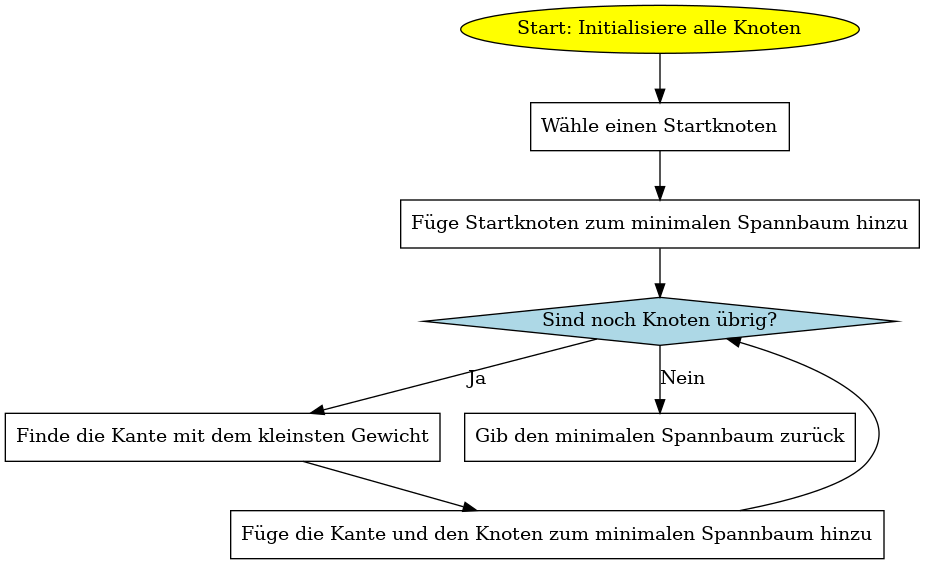

In [14]:


def prim_algorithm(graph):
    vertices = set(graph.vertices())
    # Wähle einen Startknoten
    start_vertex = vertices.pop()
    # Füge den Startknoten zum minimalen Spannbaum hinzu
    min_spanning_tree = Graph()
    min_spanning_tree.add_vertex(start_vertex)
    
    while vertices:
        # Finde die Kante mit dem kleinsten Gewicht von einem Knoten im Spannbaum zu einem Knoten außerhalb des Spannbaums
        min_weight = float('inf')
        min_edge = None
        for v1 in min_spanning_tree.vertices():
            for v2 in graph.neighbors(v1):
                if v2 in vertices:
                    weight = graph.edge_label(v1, v2)  # Gewicht der Kante zwischen v1 und v2
                    if weight < min_weight:
                        min_weight = weight
                        min_edge = (v1, v2)
        
        # Füge den Knoten zum minimalen Spannbaum hinzu
        min_spanning_tree.add_edge(min_edge[0], min_edge[1], min_weight)
        vertices.remove(min_edge[1])
    
    return min_spanning_tree

# Anwenden des Prim-Algorithmus auf den Graphen
min_spanning_tree = prim_algorithm(G)
min_spanning_tree.plot(edge_labels=True, figsize=[10, 10])
min_spanning_tree.plot(edge_labels=True, figsize=[10, 10]).save("unsersMinTree.png")

### Probe
Um zu überprüfen, ob unser Algorithmus funktioniert hat, können wir ihn mit dem Algorithmus von Sage-Math vergleichen. Wenn dieser denselben Spannbaum liefert, ist das ein Zeichen dafür, dass unser Algorithmus funktioniert.

In [15]:
weight = lambda e: e[2]
# Find the minimum spanning tree
mst_test = Graph(G.min_spanning_tree(algorithm='Prim_Boost', weight_function=weight))

# Show the minimum spanning tree
mst_test.plot(edge_labels=True, figsize=[10, 10])
mst_test.plot(edge_labels=True, figsize=[10, 10]).save("sageMinTree.png")

# Der minimale Steinerbaum

### Hilfsmethode für Kombinationen
Die Funktion `showSumWithBinomial` berechnet die Summe von Binomialkoeffizienten von ${n\choose i}$ für Werte von i von `sumRangeStart` bis `sumRangeEnd` und gibt diese Summe zusammen mit einer LaTeX-Formatierung aus. Diese Methode dient nur zur Darstellung von Kombinationen.

In [16]:
def showSumWithBinomial(sumRangeStart, sumRangeEnd, n): # Beispiel: showSumWithBinomial(0,len(R) - 2,len(S)) = 22819
    if k > n:
        print("Fehler da sumRangeStart > n")
        return 0
    else:
        countCombinations = 0
        for index in range(sumRangeStart, sumRangeEnd +1):
            countCombinations += binomial(n,index)
        show(LatexExpr( r'\sum^{' + str(sumRangeEnd) + r'}_{i='+ str(sumRangeStart) +r'}{' + str(n)+  r'\choose i}='+str(countCombinations)))
        return countCombinations



### Algorithmus
Als nächstes wollen wir den minimalen Steinerbaum finden. Zur Vereinfachung hier als Flowchart.

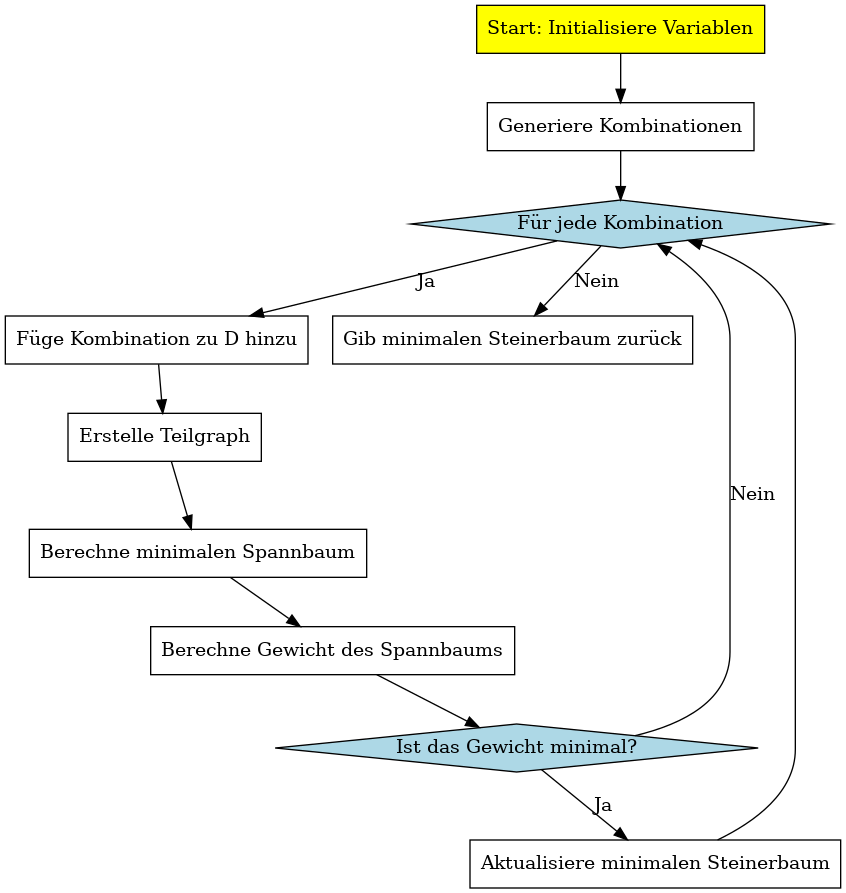

In [17]:
# Start: Initialisiere Variablen
combinations = [] # Am Ende 22819 Elemente
i = 0
k = 0
min_weight = float('inf')
min_steiner_tree = Graph()

# Generiere Kombinationen
while i <= len(R) - 2:  # = 8
    combinations += itertools.combinations(S, i) 
    i += 1

Die Anzahl der Kombinationen ist somit

In [18]:
showSumWithBinomial(0,len(R) - 2,len(S)) # vgl. oben ... combinations += itertools.combinations(S, i)

\sum^{8}_{i=0}{15\choose i}=22819

22819

0
1
2
3
4
5
6
7
8
Die benötigte Zeit für den Algorithmus, um den Steinerbaum zu berechnen: 19.1425 Sekunden


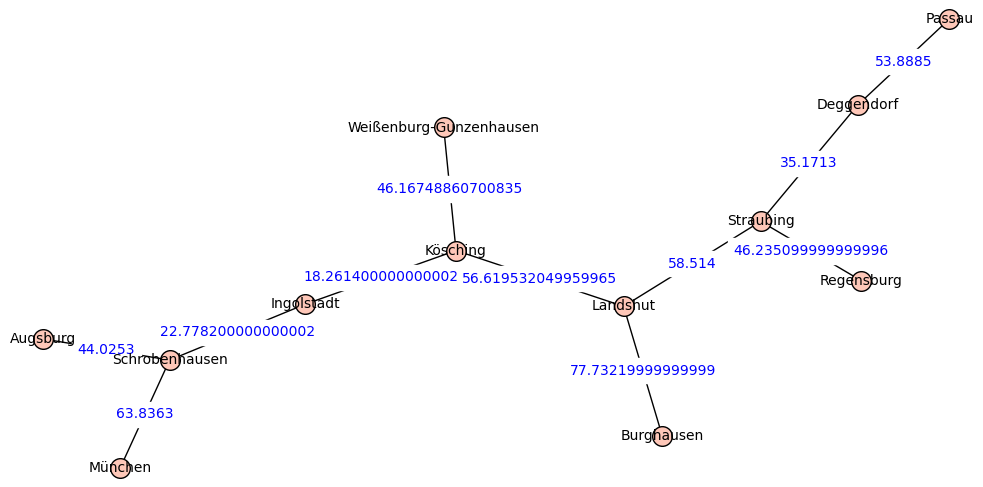

In [19]:
timeForAlgorithm = (datetime.datetime.now())

allTimes2 = [] # Wird für die Interpretation der Komplexität benötigt, die Erklärung folgt in einem anderem Punkt
snapshot = -1
m = 0
now = datetime.datetime.now()

totalTimes = [] # Hier wird die Zeit für jede berechnung gesammelt

countForLoops = 0

# Für jede Kombination
for combi in combinations:
    for_time_start = datetime.datetime.now()
    
    m += 1
    D = R.copy()  # D = ["München", "Augsburg", "Ingolstadt", "Regensburg", "Landshut", "Straubing", "Passau", "Deggendorf", "Burghausen", "Weißenburg-Gunzenhausen"]
    
    # Füge Kombination zu D hinzu
    D += combi
    
    # Erstelle Teilgraph
    G_Teil = Graph()
    for x in D:
        for y in D:
            if x != y:
                try:
                    distance = distancesAll[(x, y)]
                    G_Teil.add_edge(x, y, distance)
                except:
                    continue
    
    # Berechne minimalen Spannbaum
    min_spanning_tree = prim_algorithm(G_Teil)
    
    # Berechne Gewicht des Spannbaums
    weight = 0
    for edge in min_spanning_tree.edges():
        weight += edge[2]
    
    # Ist das Gewicht minimal?
    if weight < min_weight:
        # Aktualisiere minimalen Steinerbaum
        min_weight = weight
        min_steiner_tree = min_spanning_tree
    
    if (snapshot != len(combi)): # Diese Abfrage ist für den Algorithmus uninteressant, wir benötigen es für die Zeitmessung.
        snapshot = len(combi)
        
        # Die Durchschnittliche Zeit die wir benötigen um D + Steinerpunkt(e) auszurechnen.
        # Hinweis: Es geht nicht um die Zeit von allen allen Kombination, uns interessiert
        # vielmehr, was passiert wenn ein Element hinzukommt. Beispiel: Die Berechnung von
        # 10 Elementen ist kürzer als 11 Elemente.
        allTimes2.append((datetime.datetime.now() - now).total_seconds() / m) 
        
        now = datetime.datetime.now()
        m = 0
        print(snapshot)
    totalTimes.append([countForLoops,(datetime.datetime.now() - for_time_start).total_seconds()])
    countForLoops = countForLoops +1
    
# Gib minimalen Steinerbaum zurück
print("Die benötigte Zeit für den Algorithmus, um den Steinerbaum zu berechnen:", (datetime.datetime.now() - timeForAlgorithm).total_seconds(), "Sekunden")

min_steiner_tree.plot(edge_labels=True, figsize=[10, 10])

### Vergleich des minimalen Spannbaums mit dem minimalen Steinerbaum

In [20]:
# Berechnung der Summe der Gewichte des minimalen Spannbaums
summeDerGewichteDesMinimalenSpannbaum = 0
for edge in min_spanning_tree.edges():
    summeDerGewichteDesMinimalenSpannbaum += edge[2]
print("Der minimale Spannbaum ergibt:",summeDerGewichteDesMinimalenSpannbaum, "Glasfaser pro km")

# Berechnung der Summe der Gewichte des Steinerbaums
summeDerGewichteDesSteinerBaums = 0
for edge in min_steiner_tree.edges():
    summeDerGewichteDesSteinerBaums += edge[2]
print("Der minimale Steinerbaum ergibt:",summeDerGewichteDesSteinerBaums, "Glasfaser pro km")

# Vergleich der Kosten und Berechnung der Ersparnis in Prozent
if summeDerGewichteDesSteinerBaums < summeDerGewichteDesMinimalenSpannbaum:
    print("Ersparnis:",abs(summeDerGewichteDesMinimalenSpannbaum-summeDerGewichteDesSteinerBaums),"Glasfaser pro km." , " In Prozent also", f'{(1-summeDerGewichteDesSteinerBaums/summeDerGewichteDesMinimalenSpannbaum)*100}', "%")

Der minimale Spannbaum ergibt: 657.6357575464075 Glasfaser pro km
Der minimale Steinerbaum ergibt: 523.2293206569683 Glasfaser pro km
Ersparnis: 134.4064368894392 Glasfaser pro km.  In Prozent also 20.437823726450045 %


# Interpretation für den Aufwand

### Treppen
Nun betrachten wir unsere Messungen. Wir beobachten, dass sich die Zeit für die Berechnung erhöht, sobald sich die Anzahl der Kombinationen von D im Steineralgorithmus erhöht. Die Messungen ergeben einen treppenartigen Graphen. 
- Jede Ansammlung von Punkten (eine Stufe) repräsentiert eine Gruppe von Kombinationen mit der gleichen Anzahl von Knoten.
- Der Übergang von einer Stufe zur nächsten zeigt den zusätzlichen Rechenaufwand, der durch das Hinzufügen weiterer Knoten entsteht.
- Die Höhe jeder Stufe gibt die durchschnittliche Zeit für die Berechnung aller Kombinationen dieser Knotenmenge an.
### Ausreißer
- Diese Ausreißer könnten auf spezifische Kombinationen von Knoten zurückzuführen sein, so dass der Aufruf von `prim_algorithm(G_Teil)` im Steiner-Algorithmus etwas mehr zeit benötigt

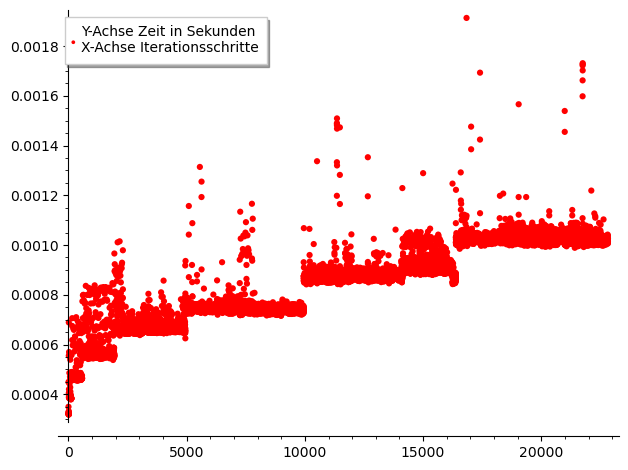

In [21]:
p = list_plot(list(totalTimes), pointsize=20, color='red', marker='o', legend_label='Y-Achse Zeit in Sekunden\nX-Achse Iterationsschritte')
p.show()


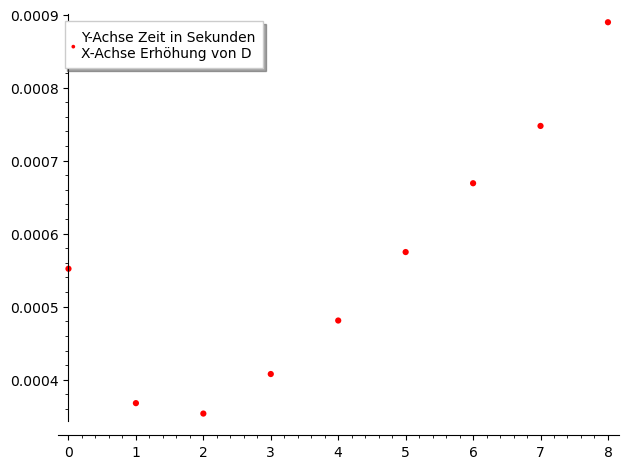

In [22]:
p = list_plot(list(zip(range(len(allTimes2)), allTimes2)), pointsize=20, color='red', marker='o', legend_label='Y-Achse Zeit in Sekunden\nX-Achse Erhöhung von D')
p.show()

### Idee zur Bestimmung des Aufwands (Werte aus Aufgabe 3)

Da sich die Kombinationen sehr schnell erhöhen, ist das Testen der Messung der Zeit extrem aufwendig. Erhöht man die Anzahl der Städte in $R$ bereits um 6, hätten wir ${25 + 6}\choose{2}$ = 465 Kombinationen allein für die API-Anfragen.

Setzen wir für für die obere Grenze 100 ($|R| = 100$) ein, und für das $n$ im Binomialkoeffizienten die Zahl 200 ($|S| = 200$), erhalten wir für $\sum_{i=0}^{100} \binom{200}{i}$ sehr viele Kombinationen. Wir können zeigen, dass die Berechnung für diese Anzahl an Kombinationen extrem lange dauert. Dazu können wir eine einfache For-Schleife ohne zusätzliche Logik verwenden, d.h., wir messen die reine Zeit, die eine For-Schleife benötigt, und multiplizieren sie mit der Anzahl der Kombinationen.

In [23]:
allCombination = showSumWithBinomial(0,100,200) 

\sum^{100}_{i=0}{200\choose i}=848743279457546778353683134709323383198353791729103086071348

In [24]:
# Zeit für 1 For Iteration 
forLoopTime = datetime.datetime.now()
for oneIteration in range(1):
    forLoopTime = n((datetime.datetime.now() - forLoopTime).total_seconds()) # Zeitmessung mit datetime
print("1 For-Iteration in Sage-Math benötigt in Sekunden")
show(forLoopTime)

1 For-Iteration in Sage-Math benötigt in Sekunden


0.0000490000000000000

Wir können diese zahl nun mit den Anzahl der Kombinationen multiplizieren

In [25]:
timeForAllCombination = forLoopTime*(allCombination)
print("D.h. benötigen alle Kombinationen in Sekunden:")
show(timeForAllCombination)
print("Umgerechnet in Jahre bis diese For-Schleife fertig wäre:")
show(timeForAllCombination / (3600 * 24 * 365))

D.h. benötigen alle Kombinationen in Sekunden:


4.15884206934198e55

Umgerechnet in Jahre bis diese For-Schleife fertig wäre:


1.31876016912163e48

#### Vermutung
Wenn man $n$ Schrittweise erhöht in
$\sum_{i=0}^{m} \binom{n}{i} \text{ wobei } n,m \in \mathbb{N}, n \geq m$, nimmt die Anzahl der Kombinationen exponentiel zu (d.h. $n$ könnte z.B. $|S|$ sein und $m$ unsere Großstädte $|R|$ wie mit Beispielwerten aus Teilaufgabe 3)

Der exponentiel Zuwachs liegt vermutlich an der Fakultät im Binomialkoeffizient $n \choose i$ =  $ \frac{n!}{i!(n - i)!}$. Durch die Fakultät wird $n$ im Zähler sehr groß, lässt man jetzt beispielsweise $i$ gegen ${\lfloor\frac{n}{2}}\rfloor$ laufen, erhählt man eine sehr große Zahl für den Binomialkoeffizienten.

### Koordinaten an einem Graphen anwenden
Für die Darstellung, wollen wir die Knoten etwas realistischer positionieren. Die Proportion der Abstände soll in etwa so sein, wie als würde man diese Abstände aus einer Landkarte ablesen. Unsere Rechnungen werden hierdurch nicht verändert, wir verändern den Graphen nur visuell.

In [26]:
def koordinatenAnwenden(graph, coords, scale=0.5):
    pos = {}
    for stadt, (x, y) in coords.items():
        pos[stadt] = (x, y)
    graph.set_pos(pos)

# Beispielhafte Verwendung:
koordinatenAnwenden(min_steiner_tree, koordinaten_dict)

# Plot erstellen ohne Hintergrundfarbe
plot = min_steiner_tree.plot(edge_labels=False, vertex_labels=True, vertex_size=0, figsize=[12, 12])

# Hintergrundfarbe auf transparent setzen
plot.matplotlib().figure.set_facecolor((1, 1, 1, 0))